# Building classifier for recipes

I actually trained the classifier using the python file 'classify_recipes.py'. 
If you want to do it in a notebook locally go ahead, it's going to take some time. 
The output of the classifier can be found in the files 'output_classifier.txt'

In [16]:
import pandas as pd
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
dataset = pd.read_pickle('./data/recipe_dataset.pkl')
dataset['type_id'] = dataset['type'].factorize()[0]
category_id_df = dataset[['type', 'type_id']].drop_duplicates().sort_values('type_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['type_id', 'type']].values)
labels = ['articles', 'recipes']

In [6]:
# prepare features
X = dataset['ocr_without_stopwords']
y = dataset['type'].values

In [7]:
# shuffle dataset
X_shuf, y_shuf = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_shuf, y_shuf, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11853,) (5081,) (11853,) (5081,)


## Naive Bayes

In [ ]:
# Naive Bayes
# initialize classifier
NB_clf = Pipeline([
	('tfidf', TfidfVectorizer(min_df=5, max_df=0.9, sublinear_tf=True, ngram_range=(1,2), analyzer='word')),
	('clf', MultinomialNB())])

params = {
	'tfidf__min_df': (0, 5, 10),
	'tfidf__max_df': (0.25, 0.50, 0.75, 0.90),
	'tfidf__analyzer': ['word'],
	'tfidf__ngram_range': [(1,1), (1,2), (1,3), (1,4), (1,5), (2, 2), (2, 3), (2, 4), (2,5), (2,6), (3,3), (3,4), (3,5)],
	'tfidf__use_idf': (True, False),
	'clf__alpha': (1e-2, 1e-3)
}

In [ ]:
# Random Search for hyper-parameters
NB_randsearch = RandomizedSearchCV(NB_clf, param_distributions=params, n_iter=50, cv=5, n_jobs=30, verbose=3)
NB_randsearch.fit(X_train, y_train)

joblib.dump(NB_randsearch, 'NB_clf.pkl')

In [ ]:
print("Naive Bayes Best Score:{}".format(NB_randsearch.best_score_))
print("Naive Bayes Best Params:{}".format(NB_randsearch.best_params_))

NB_pred = NB_randsearch.predict(X_test)

print("Accuracy Naive Bayes: {}".format(accuracy_score(y_test, NB_pred)))
scores = {}
scores['precision'] = precision_score(y_test, NB_pred, average=None)
scores['recall'] = recall_score(y_test, NB_pred, average=None)
scores['f1'] = f1_score(y_test, NB_pred, average=None)
print("Naive Bayes Precision/Recall/F1 Score:")
print("-" * 80)
print(pd.DataFrame(data=scores, index=labels))

# SVM

In [ ]:
# SVM classifier
# Initialize classifier
SVM_clf = Pipeline([('tfidf', TfidfVectorizer(min_df=5, max_df=0.75, sublinear_tf=True, ngram_range=(1, 2), analyzer='word')),
						 ('clf-svm', SGDClassifier(alpha=1e-3, random_state=42))])


params = {
	'tfidf__min_df': (0, 5),
	'tfidf__max_df': (0.50, 0.75, 0.90),
	'tfidf__analyzer': ['word'],
	'tfidf__ngram_range': [(1, 1), (1,2), (1, 3), (1,4), (1,5), (2, 2), (2, 3), (2, 4), (2,5), (3,3), (3,4), (3,5)],
	'clf-svm__alpha': (1e-2, 1e-3)
}

In [ ]:
# Random Search for hyper-parameters SVM
svm_randsearch = RandomizedSearchCV(SVM_clf, param_distributions=params, n_iter=50, cv=5, n_jobs=30,
								random_state=333, verbose=3)

svm_randsearch.fit(X_train, y_train)
joblib.dump(svm_randsearch, 'SVM_clf.pkl')

In [ ]:
print("SVM Best Score:{}".format(svm_randsearch.best_score_))
print("SVM Best Params:{}".format(svm_randsearch.best_params_))

SVM_pred = svm_randsearch.predict(X_test)

print("Accuracy SVM: {}".format(accuracy_score(y_test, SVM_pred)))
scores = {}
scores['precision'] = precision_score(y_test, SVM_pred, average=None)
scores['recall'] = recall_score(y_test, SVM_pred, average=None)
scores['f1'] = f1_score(y_test, SVM_pred, average=None)
print("SVM Precision/Recall/F1 Score:")
print("-" * 80)
print(pd.DataFrame(data=scores, index=labels))

# SVC

In [ ]:
# SVC classifier
# Initialize Linear SVC Classifier
SVC_clf = Pipeline([
	('tfidf', TfidfVectorizer(min_df=5, max_df=0.75, sublinear_tf=True, ngram_range=(1,2), analyzer='word')),
	('svc-clf', OneVsRestClassifier(LinearSVC(verbose=True, class_weight='balanced', C=1.0)))])


params = {
	'tfidf__min_df': (0, 5),
	'tfidf__max_df': (0.50, 0.75, 0.90),
	'tfidf__analyzer': ['word'],
	'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1,5), (2, 2), (2, 3), (2, 4), (2, 5), (3, 3), (3, 4), (3, 5)],
}

# Random Search for hyper-parameters
svc_randsearch = RandomizedSearchCV(SVC_clf, param_distributions=params,
									n_iter=50, cv=5, n_jobs=30,
									random_state=333, verbose=3)

svc_randsearch.fit(X_train, y_train)
joblib.dump(svc_randsearch, 'SVC_clf.pkl')

In [3]:
svc_randsearch = joblib.load('models/SVC_clf.pkl')

In [ ]:
# Random Search for hyper-parameters
svc_randsearch = RandomizedSearchCV(SVC_clf, param_distributions=params,
									n_iter=50, cv=5, n_jobs=30,
									random_state=333, verbose=3)

svc_randsearch.fit(X_train, y_train)
joblib.dump(svc_randsearch, 'SVC_clf.pkl')

In [49]:
print("SVM Best Score:{}".format(svc_randsearch.best_score_))
print("SVM Best Params:{}".format(svc_randsearch.best_params_))

SVC_pred = svc_randsearch.predict(X_test)

print("Accuracy SVC: {}".format(accuracy_score(y_test, SVC_pred)))
scores = {}
scores['precision'] = precision_score(y_test, SVC_pred, average=None)
scores['recall'] = recall_score(y_test, SVC_pred, average=None)
scores['f1'] = f1_score(y_test, SVC_pred, average=None)
print("SVC Precision/Recall/F1 Score:")
print("-" * 80)
print(pd.DataFrame(data=scores, index=labels))
pd.DataFrame(data=scores, index=labels).to_latex

SVM Best Score:0.9627942293090357
SVM Best Params:{'tfidf__max_df': 0.5, 'tfidf__min_df': 5, 'tfidf__analyzer': 'word', 'tfidf__ngram_range': (1, 2)}
Accuracy SVC: 0.9866168077150167
SVC Precision/Recall/F1 Score:
--------------------------------------------------------------------------------
                f1  precision    recall
articles  0.987761   0.985632  0.989899
recipes   0.985237   0.987810  0.982676


<bound method NDFrame.to_latex of                 f1  precision    recall
articles  0.987761   0.985632  0.989899
recipes   0.985237   0.987810  0.982676>

In [52]:
print(pd.DataFrame(data=scores, index=labels).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &        f1 &  precision &    recall \\
\midrule
articles &  0.987761 &   0.985632 &  0.989899 \\
recipes  &  0.985237 &   0.987810 &  0.982676 \\
\bottomrule
\end{tabular}



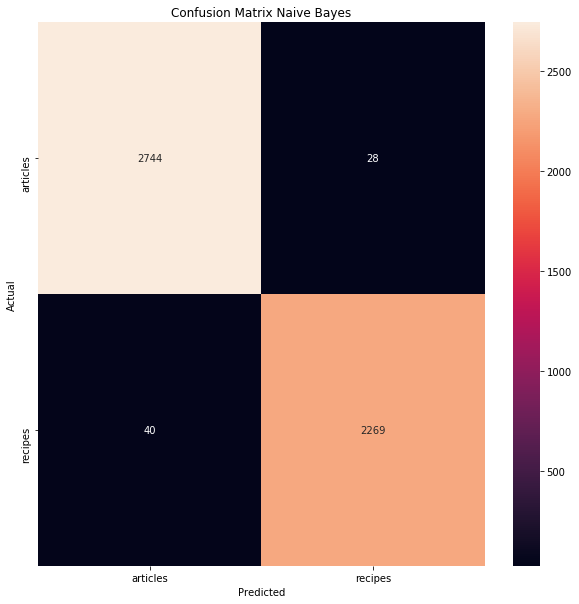

In [17]:
conf_mat = confusion_matrix(y_test, SVC_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.type.values, yticklabels=category_id_df.type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix Naive Bayes")
plt.savefig("confusion_matrix_nb.png")

# Tag Recipes in Newspapers

In [21]:
import glob

In [18]:
def load_df(name):
    '''
    options for names include trouw, volkskrant, parool, or nrc
    '''
    
    path = 'data/' + name
    allFiles = glob.glob(path + "/*.tsv")
    if name == 'nrc':
        df = pd.concat((pd.read_csv(f, delimiter='\t') for f in allFiles))
    else:
        df = pd.concat((pd.read_csv(f, delimiter='\t', header=None) for f in allFiles))
        df.columns = ['date', 'page', 'size', 'min_x', 'min_y', 'max_x', 'max_y', 'w', 'h', 'image_url', 'ocr_url', 'ocr']
    print("imported " + name + " articles")
    drop_cols = ['min_x', 'min_y', 'max_x', 'max_y', 'image_url']
    df = df.drop(drop_cols, axis=1)
    df = df.dropna(subset =['ocr']) # remove lines with empty ocr field
    df = df[~df['date'].str.contains('date')] #remove duplicate header rows
    return df

## NRC

In [22]:
nrc_df = load_df('nrc')

imported nrc articles


In [26]:
nrc_pred = svc_randsearch.predict(nrc_df['ocr'])
nrc_df['recipe'] = nrc_pred

In [30]:
nrc_df.recipe.value_counts()

articles    954515
recipes       3764
Name: recipe, dtype: int64

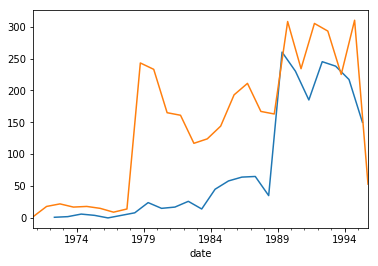

In [69]:
nrc_recipes = pd.read_csv('./data/nrc_clean_recipes.csv', index_col=0)
nrc_recipes['date'] = pd.to_datetime(nrc_recipes['date'])
nrc_recipes = nrc_recipes.set_index(['date'], drop=False)
nrc_recipes['recipe'][nrc_recipes['recipe'] == 1].resample('12M').count().plot()

nrc_df['date'] = pd.to_datetime(nrc_df['date'])
nrc_df = nrc_df.set_index(['date'], drop=False)
nrc_df['recipe'][nrc_df.recipe == 'recipes'].resample('12M').count().plot()

In [ ]:
nrc_recipes_classified = nrc_df[nrc_df.recipe == 'recipes']
nrc_recipes_classified.to_csv('data/nrc_recipes_classified.csv')

## Volkskrant

In [36]:
vk_df = load_df('volkskrant')

imported volkskrant articles


In [37]:
vk_pred = svc_randsearch.predict(vk_df['ocr'])
vk_df['recipe'] = vk_pred

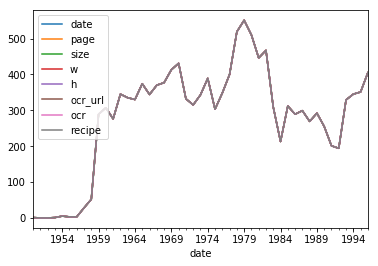

In [44]:
vk_df['date'] = pd.to_datetime(vk_df['date'])
vk_df = vk_df.set_index(['date'], drop=False)
vk_df[vk_df.recipe == 'recipes'].resample('12M').count().plot()

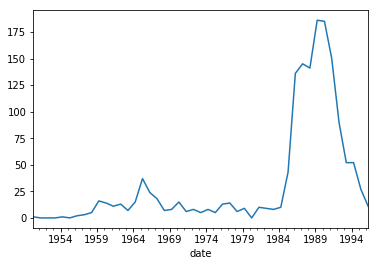

In [78]:
vk_recipes = pd.read_csv('./data/vk_clean_recipes.csv', index_col=0)
vk_recipes['date'] = pd.to_datetime(vk_recipes['date'])
vk_recipes = vk_recipes.set_index(['date'], drop=False)

vk_df[vk_df.recipe == 'recipes'].resample('12M').count().plot()
vk_recipes['recipe'][vk_recipes['recipe'] == 1].resample('12M').count().plot()

In [46]:
vk_recipes_classified = vk_df[vk_df.recipe == 'recipes']
vk_recipes_classified.to_csv('data/vk_recipes_classified.csv')

## Trouw

In [56]:
trouw_df = load_df('trouw')

/Users/melvinwevers/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()


imported trouw articles


In [55]:
trouw_pred = svc_randsearch.predict(trouw_df['ocr'])
trouw_df['recipe'] = trouw_pred
trouw_df.recipe.value_counts()

In [ ]:
trouw_recipes = pd.read_csv('./data/trouw_clean_recipes.csv', index_col=0)
trouw_recipes['date'] = pd.to_datetime(trouw_recipes['date'])
trouw_recipes = trouw_recipes.set_index(['date'], drop=False)
trouw_recipes['recipe'][trouw_recipes['recipe'] == 1].resample('12M').count().plot(ax=ax[2], title = 'Trouw')
trouw_df['recipe'][trouw_df.recipe == 'recipes'].resample('12M').count().plot()

In [59]:
trouw_recipes_classified = trouw_df[trouw_df.recipe == 'recipes']
trouw_recipes_classified.to_csv('data/trouw_recipes_classified.csv')

## Parool

In [60]:
parool_df = load_df('parool')

/Users/melvinwevers/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()


imported parool articles


In [61]:
parool_pred = svc_randsearch.predict(parool_df['ocr'])
parool_df['recipe'] = parool_pred
parool_df.recipe.value_counts()

In [94]:
parool_recipes = pd.read_csv('./data/parool_clean_recipes.csv')
parool_recipes['date'] = parool_recipes['date'].astype('datetime64[ns]')
parool_recipes['date'] = pd.to_datetime(parool_recipes['date'])
parool_recipes = parool_recipes.set_index(['date'], drop=False)
parool_df[parool_df.recipe == 'recipes'].resample('12M').count().plot()

1    1481
0     971
Name: recipe, dtype: int64

In [65]:
parool_recipes_classified = parool_df[parool_df.recipe == 'recipes']
parool_recipes_classified.to_csv('data/parool_recipes_classified.csv')

# Visualize recipes found through query words and classifier
Orange = classifier <br>
Blue = query words

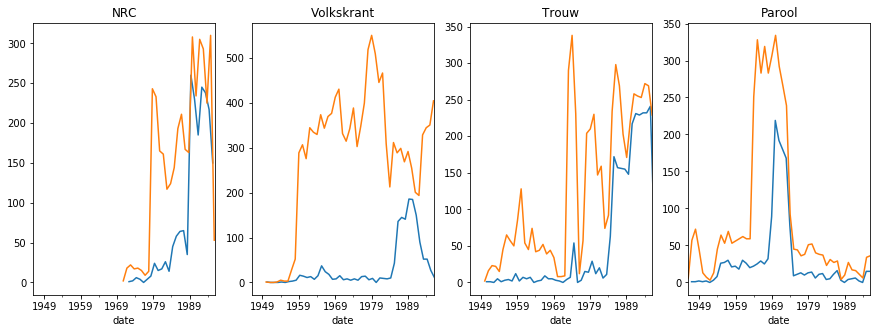

In [184]:
from matplotlib.ticker import MaxNLocator
import numpy as np

fig, ax = plt.subplots(1, 4, figsize=(15,5), sharex=True)

nrc_recipes['recipe'][nrc_recipes['recipe'] == 1].resample('12M').count().plot(ax=ax[0], title="NRC")
nrc_df['recipe'][nrc_df.recipe == 'recipes'].resample('12M').count().plot(ax=ax[0])

vk_recipes['recipe'][vk_recipes['recipe'] == 1].resample('12M').count().plot(ax=ax[1])
vk_df['recipe'][vk_df.recipe == 'recipes'].resample('12M').count().plot(ax=ax[1], title="Volkskrant")

trouw_recipes['recipe'][trouw_recipes['recipe'] == 1].resample('12M').count().plot(ax=ax[2], title = 'Trouw')
trouw_df['recipe'][trouw_df.recipe == 'recipes'].resample('12M').count().plot(ax=ax[2])

parool_recipes['recipe'][parool_recipes['recipe'] == 1].resample('12M').count().plot(ax=ax[3], title = 'Parool')
parool_df['recipe'][parool_df.recipe == 'recipes'].resample('12M').count().plot(ax=ax[3])

plt.tight_layout
plt.savefig('classifier_newspapers.png', dpi=300)